# Quantifying uncertainty via bootstrap

There is no Python equivalent of the `boot` library in R. Bootstrap, however is easy to implement, so we will cover a simple parametric implementation. The file `boot_utils.py` contains functions for generating bootstrap replicates and confidence intervals. 


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Magic command Needed for showing plots in jupyter notebooks
%matplotlib inline

In [2]:
# Adjust plot dpi and other graphical parameters
plt.rcParams.update(**{
    'figure.dpi':150,
    'figure.figsize':(4,3)
})

## Recap: Non-linear regression

**Data**: $\{(\mathbf{x}_i,y_i)  \;\;\mathrm{ for } \;i = 1,\ldots,n\}$

**Model**: $\widehat{y} = g(\mathbf{x},\boldsymbol\theta)$ - not linear in the parameters

**Fitting the model**: Choose $\boldsymbol\theta$ to minimize sum-squared error:

$$
\widehat{\boldsymbol\theta} =\underset{\boldsymbol\theta}{\arg\min} \;\sum_{i=1}^{n}\left[y_i - g(\mathbf{x}_i,\boldsymbol\theta) \right]^2
$$

### Manufacturing learning curve data

y - relative efficiency of operation

Two independent variables/predictors:
    
    1. Location - 0 or 1 
    2. Week number

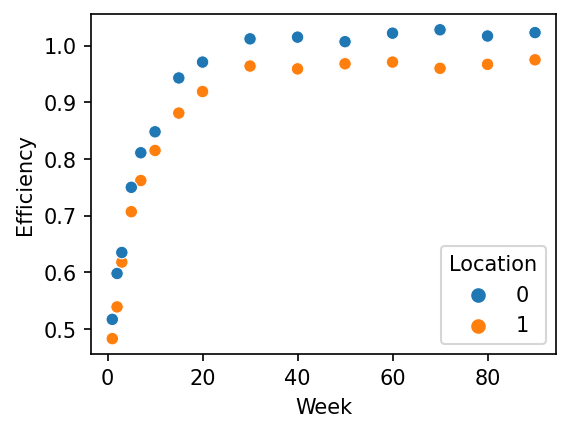

In [3]:
# read car data
mlc = pd.read_csv('../data/MLC.csv')


# Scatter plot of Efficiency vs Week for each facility
fig,ax = plt.subplots(1,1)
_ = sns.scatterplot(
    data=mlc,
    x='Week',
    y='Efficiency',
    hue='Location',
    ax=ax
)

The model we fitted last week was

$$
\widehat{y} = g(\mathbf{x},\theta) = \theta_0 + \theta_1x_1 + \theta_3\exp(\theta_2x_2)
$$

where $x_1$ is the location and $x_2$ is the Week Number. We discussed two optimization functions from `scipy.optimize` to minimize the sum squared error:

1. `minimize`: General non-linear optimization function. Not just one algorithm. We used the defaults.
2. `curve_fit`: Optimization using the least squares algorithm (equivalent of `nls` in `R`

In [4]:
def lc_model(x,theta):
    '''
    Function which returns the model:
        y = theta_0 + theta_1*Location + theta_3\exp{theta_2*Week}
    
    first column of x is Location
    second column of x is Week
    '''
    return theta[0]+theta[1]*x[:,0]+theta[3]*np.exp(theta[2]*x[:,1])

def sum_squared_error(theta,x,y):
    '''
    Function to be minimized wrt theta
    '''
    y_hat =  lc_model(x,theta)
    return np.sum((y-y_hat)**2)

theta0 = np.array([1,0,-.5,-.3]) # initial guess

res_nlm = minimize(
    fun=sum_squared_error, # loss function
    x0 = theta0 , # initial guess
    args=(mlc[['Location','Week']].values,mlc['Efficiency'].values), # (x,y) args to sum_squared_error
    #options = {'disp':True},
)

print(res_nlm)

      fun: 0.003292682812275255
 hess_inv: array([[ 0.0549408 , -0.03653306,  0.0263074 , -0.01978301],
       [-0.03653306,  0.07357654,  0.0004607 ,  0.00422141],
       [ 0.0263074 ,  0.0004607 ,  0.07875261,  0.08266582],
       [-0.01978301,  0.00422141,  0.08266582,  0.27159382]])
      jac: array([ 3.82191502e-07, -2.01343209e-06,  9.34698619e-07, -4.00817953e-07])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 13
     njev: 20
   status: 0
  success: True
        x: array([ 1.01559846, -0.04726681, -0.13479542, -0.55244245])


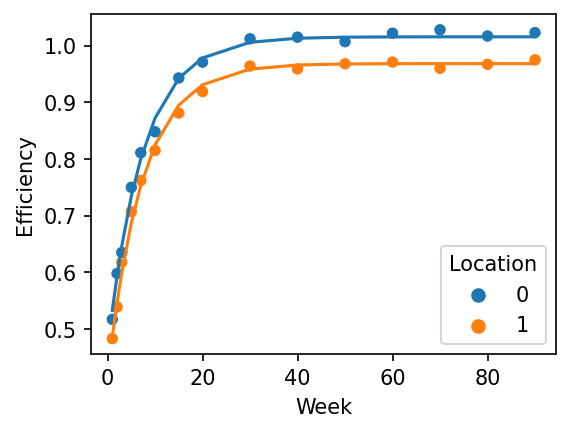

In [5]:
# visualize the fit
fig,ax = plt.subplots(1,1,figsize=(4,3))
_ = sns.scatterplot(
    data=mlc,
    x='Week',
    y='Efficiency',
    hue='Location',
    ax=ax
)

# compute model predictions with the optimized parameters
yhat = lc_model(mlc[['Location','Week']].values,res_nlm.x)

# Visualize the curve fit 
_ = sns.lineplot(
    data = mlc,
    x = 'Week',
    y = yhat,
    hue = 'Location',
    ax=ax,
    legend=False
)

Since the parameters are estimated from data, there will be some uncertainty in the estimates. In this lab, we will use bootstrap to quantify this uncertainty in the parameters, and see how this uncertainty propogates to the model's predictions. 

## Bootstrap procedure

Refer to Slides 29, 30 and 32.

1. Draw a random sample of the same size $n$ from the original sample of $n$ observations with (with replacement).

In [6]:
# Set seed for reproducibility
np.random.seed(345)
idxs = np.random.choice(mlc.shape[0],size=mlc.shape[0],replace=True)
idxs

array([24, 16, 19, 15,  9, 29, 10, 11, 24,  4, 29,  3,  4, 10,  1, 23, 20,
       16,  9, 22, 19, 12, 24,  0, 14, 11, 19, 13, 17,  5])

2. Estimate the parameters by minimizing the loss function on this "boostrap" sample.

We will write a function that returns the optimized parameters for this bootstrapped samples.

In [7]:
# statistic function
def mlc_fit(dat,idxs,theta0):
    '''
    Fits the learning curve model on samples corresponding to indices `idxs`
    and returns the parameters
    '''
    
    # sample corresponding to index
    # pandas dataframes or Series - use .iloc
    dat_idx = dat.iloc[idxs,:]
    
    # Optimize parameters
    res_nlm = minimize(
        fun=sum_squared_error, # function to be minimized
        x0=theta0, # initial guess
        # (x,y) args to sum_squared_error
        args=(dat_idx[['Location','Week']].values,dat_idx['Efficiency'].values),
    )
    
    # return optimized parameters
    return res_nlm.x

In [8]:
# estimate from bootstraped sample
theta_idx = mlc_fit(mlc,idxs=idxs,theta0=theta0)
theta_idx

array([ 1.01551289, -0.04711176, -0.13859463, -0.55925807])

In [9]:
# original estimate
theta0 = np.array([1.,-0.05,-0.14,-0.55])
theta_orig = mlc_fit(mlc,idxs=np.arange(mlc.shape[0]),theta0=theta0)
theta_orig

array([ 1.01559832, -0.04726667, -0.1347955 , -0.55244241])

3. Repeat steps 1 and 2 for a large number of replicates $B$. Denote the estimates by $\{\widehat{\theta}^b\}_{b=1}^B$.

The following function mimics the `boot::boot` function in R.

In [10]:
# bootstrap function
def boot(data,statistic,r,**kwargs):
    '''
    Generate `r` bootstrap replicates of a statistic applied to data.
    
    Returns
    ---------
    A dictionary with the following keys:
        t0: array
            statistic applied to the original data
        t: array
            A 2D array with `r` rows each of which is a bootstrap replicate
            of the result of calling `statistic`
    '''
    
    # create dictionary object
    res_boot = {}
    
    # compute the statistic applied to original data
    res_boot['t0'] = statistic(data,np.arange(data.shape[0]),**kwargs)
    
    # run bootstrap loop
    t_list = [None]*r
    for i in range(r):
        # draw bootstrap sample and compute statistic
        idxs = np.random.choice(data.shape[0],size=data.shape[0],replace=True)
        t_list[i] = statistic(data,idxs,**kwargs)
    
    # combine results into array
    res_boot['t'] = np.row_stack(t_list)
    
    # return final argument
    return res_boot

In [11]:
# Set seed for reproducibility
np.random.seed(1234)

# run bootstrap
mlc_boot = boot(mlc,mlc_fit,1000,theta0=theta0)

# first 10 bootstrap replicates
mlc_boot['t'][:10,:] 

array([[ 1.0180255 , -0.05616204, -0.13397868, -0.56191401],
       [ 1.01699714, -0.04972649, -0.13655082, -0.54633973],
       [ 1.01569915, -0.05103247, -0.13043553, -0.55452675],
       [ 1.0107995 , -0.04136153, -0.1360432 , -0.55081256],
       [ 1.01061006, -0.04514755, -0.13443987, -0.54757262],
       [ 1.0110903 , -0.04020263, -0.14334173, -0.55957115],
       [ 1.01046355, -0.04095877, -0.13675455, -0.55418284],
       [ 1.01429901, -0.0463736 , -0.13600762, -0.55544861],
       [ 1.01436494, -0.04910279, -0.13859233, -0.55809836],
       [ 1.01553705, -0.04527971, -0.14722372, -0.5678248 ]])

In [12]:
# original estimate
mlc_boot['t0']

array([ 1.01559832, -0.04726667, -0.1347955 , -0.55244241])

## Plot of the bootstrap sampling distributions

Using the bootstrap estimates, we can compute the histograms for each parameter estimates. There are is no equivalent of `boot::plot.boot`, but it is easy to implement.

In [13]:
# for normal Q-Q plots
from scipy.stats import probplot

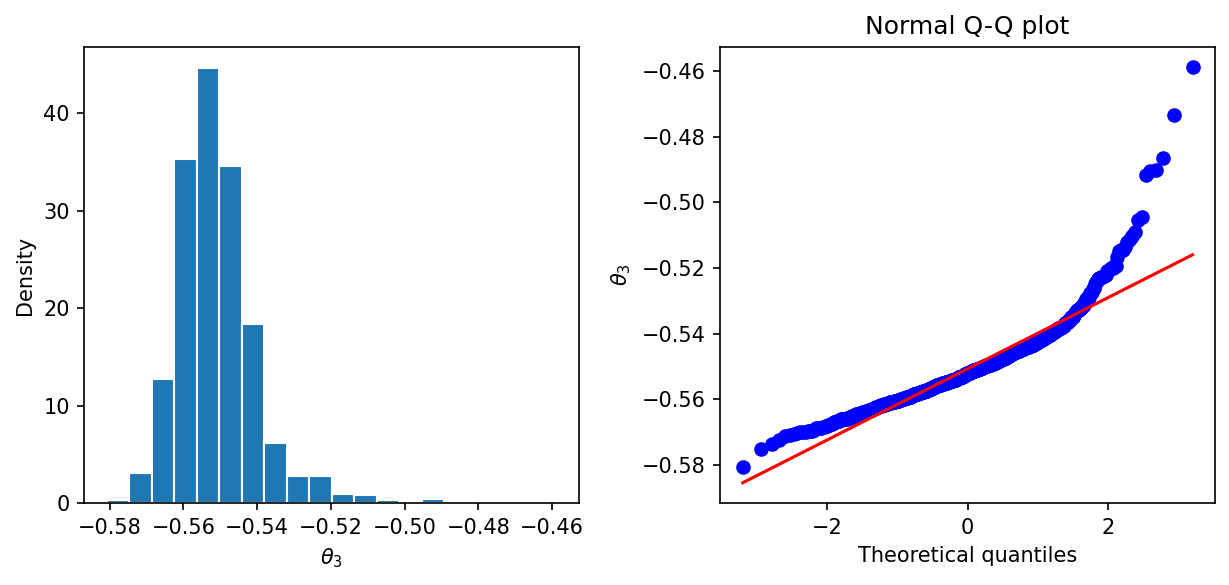

In [14]:
param_idx = 3

fig,axs = plt.subplots(1,2,figsize=(8.3,4))

label = r'$\theta_%d$'%(param_idx)

# First plot-histogram
_ = axs[0].hist(mlc_boot['t'][:,param_idx],bins=20,density=True,edgecolor='w')
_ = axs[0].set_xlabel(label)
_ = axs[0].set_ylabel('Density')

# Second plot - QQ plot
_ =  probplot(mlc_boot['t'][:,param_idx],plot=axs[1])
_ = axs[1].set_ylabel(label)
_ = axs[1].set_title('Normal Q-Q plot')

fig.tight_layout()

## Standard errors and condidence intervals for the parameters


- Average of all bootstrapped estimates:

$$
\overline{\widehat{\theta}} = \frac{1}{B}\sum_{b=1}^{B} \widehat{\theta}^b
$$

- Standard error for $\widehat{\theta}$ (the original estimate)

$$
\mathrm{SE}\left(\widehat{\theta}\right) = 
\sqrt{\frac{\sum_{b=1}^{B} \left(\widehat{\theta}^b - \overline{\widehat{\theta}} \right)^2}{B-1}}
$$

In [15]:
# standard errors
se_boot = np.std(mlc_boot['t'],axis=0)
se_boot

array([0.00307352, 0.00403   , 0.00592963, 0.01160081])

In [16]:
mlc_boot['t']

array([[ 1.0180255 , -0.05616204, -0.13397868, -0.56191401],
       [ 1.01699714, -0.04972649, -0.13655082, -0.54633973],
       [ 1.01569915, -0.05103247, -0.13043553, -0.55452675],
       ...,
       [ 1.01600976, -0.04856516, -0.13842242, -0.55713816],
       [ 1.01381289, -0.04844448, -0.13561969, -0.55418641],
       [ 1.01893829, -0.0531589 , -0.13183429, -0.5321874 ]])

- **Crude $1-\alpha$ Confidence intervals**

$$
\widehat{\theta} - z_{\alpha/2} \mathrm{SE}\left(\widehat{\theta}\right) \leq \theta < \widehat{\theta} - z_{\alpha/2} \mathrm{SE}\left(\widehat{\theta}\right)
$$

- **Reflected $1-\alpha$ Confidence intervals**

$$
\widehat{\theta} - \left(\widehat{\theta}_{\alpha/2} - \widehat{\theta}\right) \leq \theta < \widehat{\theta} + \left(\widehat{\theta}-\widehat{\theta}_{1-\alpha/2} \right)
$$



The function `boot_ci` in the file `boot_utils.py` returns either confidence interval. The arguments and values are similar to those of `boot::boot.ci` in R. 

In [17]:
from boot_utils import boot_ci

In [18]:
crude_ci = boot_ci(mlc_boot,3,kind='norm',conf_list=[0.95])
crude_ci.round(3)

,lower,upper
conf,,
0.95,-0.575,-0.53


In [19]:
reflected_ci = boot_ci(mlc_boot,3,kind='basic',conf_list=[0.95])
reflected_ci.round(3)

,lower,upper
conf,,
0.95,-0.583,-0.537


## Confidence intervals and prediction intervals on the predicted response

So far, we have computed confidence intervals for the parameters. We will now compute confidence intervals for the predictions, which probably are of more interest.


**Future response**: $Y^* = g(x^*,\theta) + \epsilon^*$

Two sets of intervals

- Confidence interval on $E[Y^*] = g(x^*,\theta)$
    - uncertainty due to not knowing $\theta$
- Prediction iterval on $Y^*$
    - uncertainty due to not knowing $\theta$ and the randomness from the unexplained portion of the model.
     
     
In this notebook, we will estimate crude intervals for both.

In [20]:
# New data point - Week 15 at location 1
# model function expects a n_new x 2 array
x_new = np.array([1.,15]).reshape(1,-1)
x_new

array([[ 1., 15.]])

In [21]:
# prediction of the original model
y_pred = lc_model(x_new,mlc_boot['t0'])
y_pred.round(3)

array([0.895])

### Confidence interval

In [22]:
# loop across the bootstrap estimates of the model
y_pred_boot = np.concatenate([
    lc_model(x_new,theta) for theta in mlc_boot['t']
])

y_pred_boot

array([0.88654927, 0.89681533, 0.88628564, 0.89786292, 0.89257647,
       0.9057147 , 0.8982561 , 0.8957094 , 0.89546102, 0.90786409,
       0.89778249, 0.89059985, 0.89263654, 0.88922646, 0.89866846,
       0.89794656, 0.88876884, 0.89221443, 0.89130735, 0.89811096,
       0.89649977, 0.88443394, 0.90035968, 0.89376239, 0.88680284,
       0.89897998, 0.89690623, 0.89408879, 0.88941019, 0.89236731,
       0.90082598, 0.89420924, 0.90127351, 0.89762821, 0.89950866,
       0.89949747, 0.89640066, 0.89381877, 0.89606809, 0.89207121,
       0.8945069 , 0.89079697, 0.89186675, 0.89866904, 0.89069188,
       0.89367519, 0.88854698, 0.88820238, 0.89260229, 0.8955655 ,
       0.89566492, 0.89821198, 0.89663542, 0.8891261 , 0.89921905,
       0.90248788, 0.89328673, 0.89015542, 0.8945957 , 0.90062952,
       0.89505731, 0.89759813, 0.89850865, 0.8897317 , 0.8883801 ,
       0.89922613, 0.88695551, 0.89301971, 0.88663563, 0.89277158,
       0.90235607, 0.89017887, 0.89345324, 0.88936694, 0.89757

In [23]:
# print the quantiles
np.quantile(y_pred_boot,[0,0.25,0.5,0.75,1]).round(3)

array([0.88 , 0.891, 0.894, 0.898, 0.912])

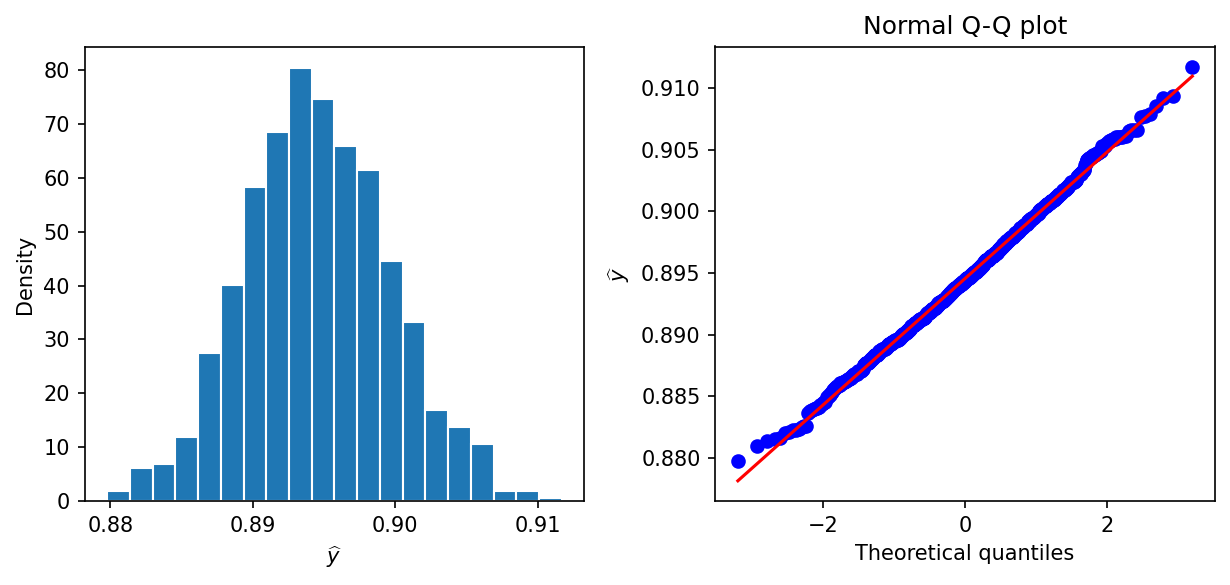

In [24]:
# distribution of predictions
fig,axs = plt.subplots(1,2,figsize=(8.3,4))

label = r'$\widehat{y}$'

# First plot-histogram
_ = axs[0].hist(y_pred_boot,bins=20,density=True,edgecolor='w')
_ = axs[0].set_xlabel(label)
_ = axs[0].set_ylabel('Density')

# Second plot - QQ plot
_ =  probplot(y_pred_boot,plot=axs[1])
_ = axs[1].set_ylabel(label)
_ = axs[1].set_title('Normal Q-Q plot')

fig.tight_layout()

In [25]:
# standard error
se_y_pred = y_pred_boot.std()
se_y_pred

0.005119153232894065

In [26]:
# crude 95% confidence interval
from scipy.stats import norm

conf = 0.95
alpha = 1-conf
ci_lower = y_pred + norm.ppf(alpha/2)*se_y_pred
ci_upper = y_pred + norm.ppf(1-alpha/2)*se_y_pred

# print them together
np.column_stack([ci_lower,ci_upper]).round(3)

array([[0.885, 0.905]])

### Prediction intervals

Standard error for response: $\sqrt{\mathrm{SE}\left[g(\mathbf{x},\widehat{\boldsymbol\theta})\right]^2 + \widehat{\sigma}^2}$

In [27]:
# calculate MSE - estimate of error variance see slide 45 for example
df_theta = res_nlm.x.shape[0]
mse = res_nlm.fun/(mlc.shape[0]-df_theta) # Mean squared error with correct degrees of freedom
mse

0.00012664164662597136

In [28]:
# standard error for the response
se_y = np.sqrt(y_pred_boot.var() + mse)

conf = 0.95
alpha = 1-conf
pi_lower = y_pred + norm.ppf(alpha/2)*se_y
pi_upper = y_pred + norm.ppf(1-alpha/2)*se_y

# print them together
np.column_stack([pi_lower,pi_upper])

array([[0.8709573 , 0.91941995]])

### Computing CI/PI for multiple inputs - vectorized operations

In [29]:
from itertools import product
x1_new = np.array([0.,1.])
x2_new = [1,45,90]

# New inputs - Weeks 1,45,90 at the two locations
x_new = np.array(list(product(x1_new,x2_new)))
x_new

array([[ 0.,  1.],
       [ 0., 45.],
       [ 0., 90.],
       [ 1.,  1.],
       [ 1., 45.],
       [ 1., 90.]])

In [30]:
y_pred = lc_model(x_new,mlc_boot['t0'])
y_pred

array([0.53282187, 1.01431615, 1.01559534, 0.4855552 , 0.96704948,
       0.96832867])

In [31]:
# predictions from bootstrap replicates of the model
# notice that concatenate is replaced by row_stack
y_pred_reps = np.row_stack([
    lc_model(x_new,theta) for theta in mlc_boot['t']]
)

# pretty print array
with np.printoptions(formatter={'float':lambda x: '%5.3f'%x},linewidth=100):
    print(y_pred_reps[:5,:])

[[0.527 1.017 1.018 0.470 0.961 0.962]
 [0.540 1.016 1.017 0.491 0.966 0.967]
 [0.529 1.014 1.016 0.478 0.963 0.965]
 [0.530 1.010 1.011 0.489 0.968 0.969]
 [0.532 1.009 1.011 0.487 0.964 0.965]]


In [32]:
lc_model(x_new,mlc_boot['t'][0,:])

array([0.52657062, 1.01667252, 1.01802224, 0.47040858, 0.96051048,
       0.9618602 ])

In [33]:
# Compute standard deviation across rows
se_y_pred = y_pred_reps.std(axis=0)

se_y_pred

array([0.00906881, 0.00295354, 0.00307276, 0.00876387, 0.0026725 ,
       0.00278454])

In [34]:
# 95% confidence interval
conf = 0.95
alpha = 1-conf
ci_lower = y_pred + norm.ppf(alpha/2)*se_y_pred
ci_upper = y_pred + norm.ppf(1-alpha/2)*se_y_pred

# print them together
np.column_stack([ci_lower,ci_upper]).round(3)

array([[0.515, 0.551],
       [1.009, 1.02 ],
       [1.01 , 1.022],
       [0.468, 0.503],
       [0.962, 0.972],
       [0.963, 0.974]])